<a href="https://colab.research.google.com/github/ctarrington/data-science-hw/blob/master/dbda/ch09-heirarchical-models/heirarchical_binomial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
from runpy import run_path

az.style.use('arviz-darkgrid')
%matplotlib inline

In [2]:
!rm -rf data-science-hw
!git clone https://github.com/ctarrington/data-science-hw.git

base_path = './data-science-hw/dbda/ch08-basic-models/'
Coin = run_path(base_path+'/mint.py').get('Coin')
Mint = run_path(base_path+'/mint.py').get('Mint')

Cloning into 'data-science-hw'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 200 (delta 93), reused 47 (delta 13), pack-reused 0
Receiving objects: 100% (200/200), 6.53 MiB | 18.68 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [13]:
coins_per_mint = 5
mint = Mint(0.2, 0.01)
coins = mint.make_coins(coins_per_mint)

mint = Mint(0.8, 0.01)
mint.make_coins(coins_per_mint, coins)

In [14]:
flips = []
for ctr in range(50):
  for coin in coins:
    coin.flip(flips)

In [15]:
df = pd.DataFrame(flips, columns=['category_id', 'individual_id', 'successes'])
min_category_id = np.min(df['category_id'])
min_individual_id = np.min(df['individual_id'])

df['category_id'] = df['category_id'] - min_category_id
df['individual_id'] = df['individual_id'] - min_individual_id
df.head()

,category_id,individual_id,successes
0,0,0,0
1,0,1,1
2,0,2,0
3,0,3,1
4,0,4,0


In [16]:
consolidated = df.groupby(['category_id', 'individual_id']).agg(['sum', 'count']).reset_index()
consolidated.columns = consolidated.columns.map(' '.join).str.strip()

consolidated.rename(columns={'successes sum': 'successes', 'successes count': 'attempts'}, inplace=True)
print(consolidated)

   category_id  individual_id  successes  attempts
0            0              0          7        50
1            0              1         14        50
2            0              2          4        50
3            0              3         12        50
4            0              4          4        50
5            1              5         36        50
6            1              6         42        50
7            1              7         41        50
8            1              8         36        50
9            1              9         38        50


In [23]:
num_individuals = len(consolidated)
num_categories = len(np.unique(consolidated['category_id']))

print('num_individuals', num_individuals, 'num_categories', num_categories)

individual_id = consolidated['individual_id']
category_id = consolidated['category_id']


num_individuals 10 num_categories 2


## No Heirarchy - Individuals

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_individual]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:02<00:00, 944.56it/s]


                  mean     sd  hpd_3%  ...  ess_bulk  ess_tail  r_hat
p_individual[0]  0.154  0.050   0.072  ...    5537.0    3276.0    1.0
p_individual[1]  0.289  0.064   0.177  ...    4808.0    3058.0    1.0
p_individual[2]  0.096  0.041   0.026  ...    5081.0    2951.0    1.0
p_individual[3]  0.249  0.058   0.138  ...    5185.0    3172.0    1.0
p_individual[4]  0.096  0.041   0.028  ...    4483.0    2885.0    1.0
p_individual[5]  0.712  0.061   0.597  ...    4759.0    2733.0    1.0
p_individual[6]  0.827  0.051   0.731  ...    5031.0    3245.0    1.0
p_individual[7]  0.807  0.053   0.705  ...    5213.0    3150.0    1.0
p_individual[8]  0.711  0.061   0.593  ...    5140.0    3161.0    1.0
p_individual[9]  0.749  0.058   0.641  ...    4516.0    2808.0    1.0

[10 rows x 11 columns]


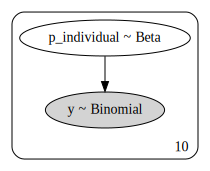

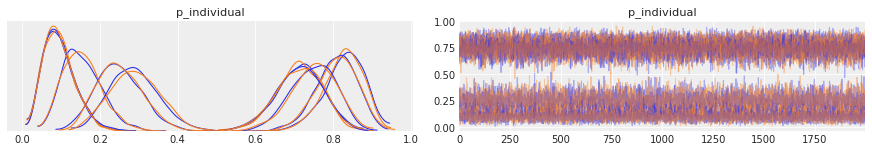

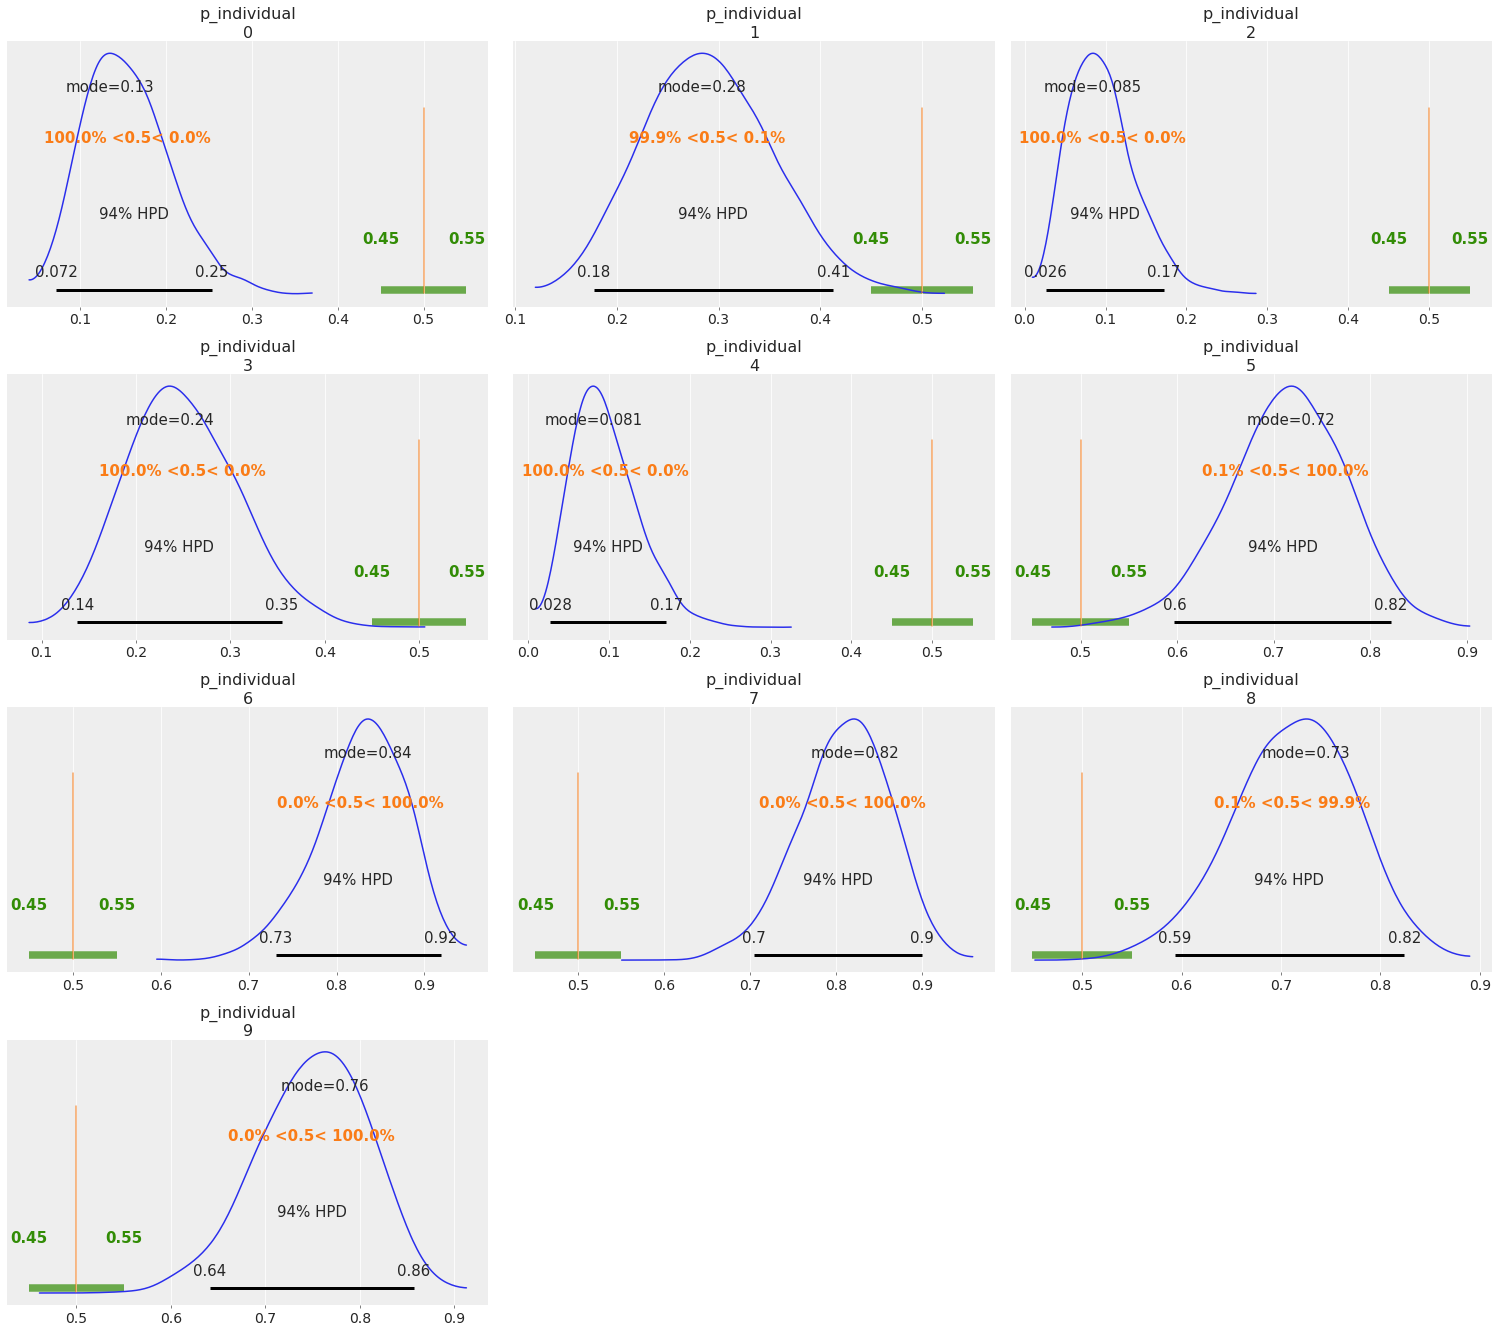

In [21]:
with pm.Model() as model_nh:
  p_individual = pm.Beta('p_individual', alpha=1., beta=1., shape=num_individuals)   # uniform prior
  
  y = pm.Binomial('y', n=consolidated['attempts'], p=p_individual[individual_id], observed=consolidated['successes']) # likelihood p(y|θ)

  trace_nh = pm.sample(2000, random_seed=123)
  print(az.summary(trace_nh))
  pm.traceplot(trace_nh)
  az.plot_posterior(trace_nh, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model_nh)

## Heirarchy - No Overall


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_individual, concentration_category, p_category]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:05<00:00, 468.77it/s]


                             mean     sd  hpd_3%  ...  ess_bulk  ess_tail  r_hat
p_category[0]               0.192  0.057   0.094  ...    3814.0    2844.0    1.0
p_category[1]               0.744  0.061   0.632  ...    4865.0    2931.0    1.0
concentration_category[0]  12.068  5.826   2.189  ...    4456.0    2803.0    1.0
concentration_category[1]  14.066  6.304   3.400  ...    4432.0    2934.0    1.0
p_individual[0]             0.148  0.045   0.073  ...    7292.0    3288.0    1.0
p_individual[1]             0.263  0.056   0.157  ...    6054.0    3103.0    1.0
p_individual[2]             0.100  0.039   0.036  ...    6242.0    3018.0    1.0
p_individual[3]             0.229  0.053   0.126  ...    6194.0    2924.0    1.0
p_individual[4]             0.099  0.040   0.026  ...    6669.0    2681.0    1.0
p_individual[5]             0.726  0.056   0.622  ...    7310.0    3113.0    1.0
p_individual[6]             0.820  0.049   0.729  ...    6239.0    2764.0    1.0
p_individual[7]             

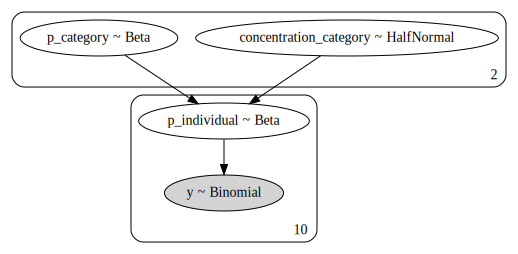

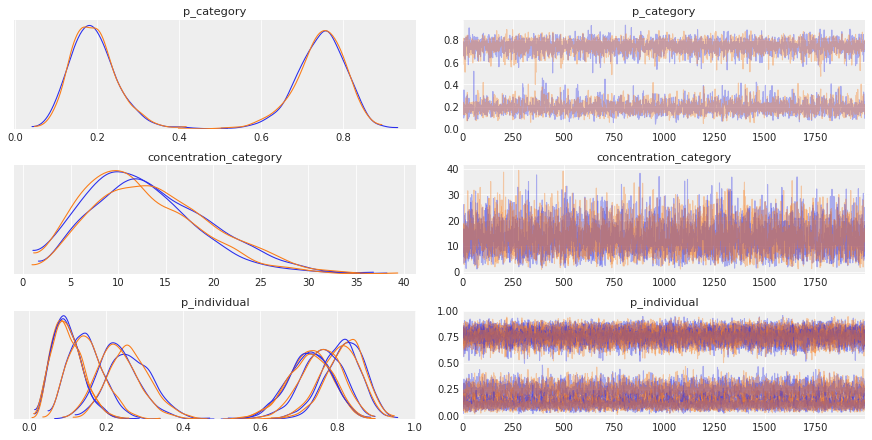

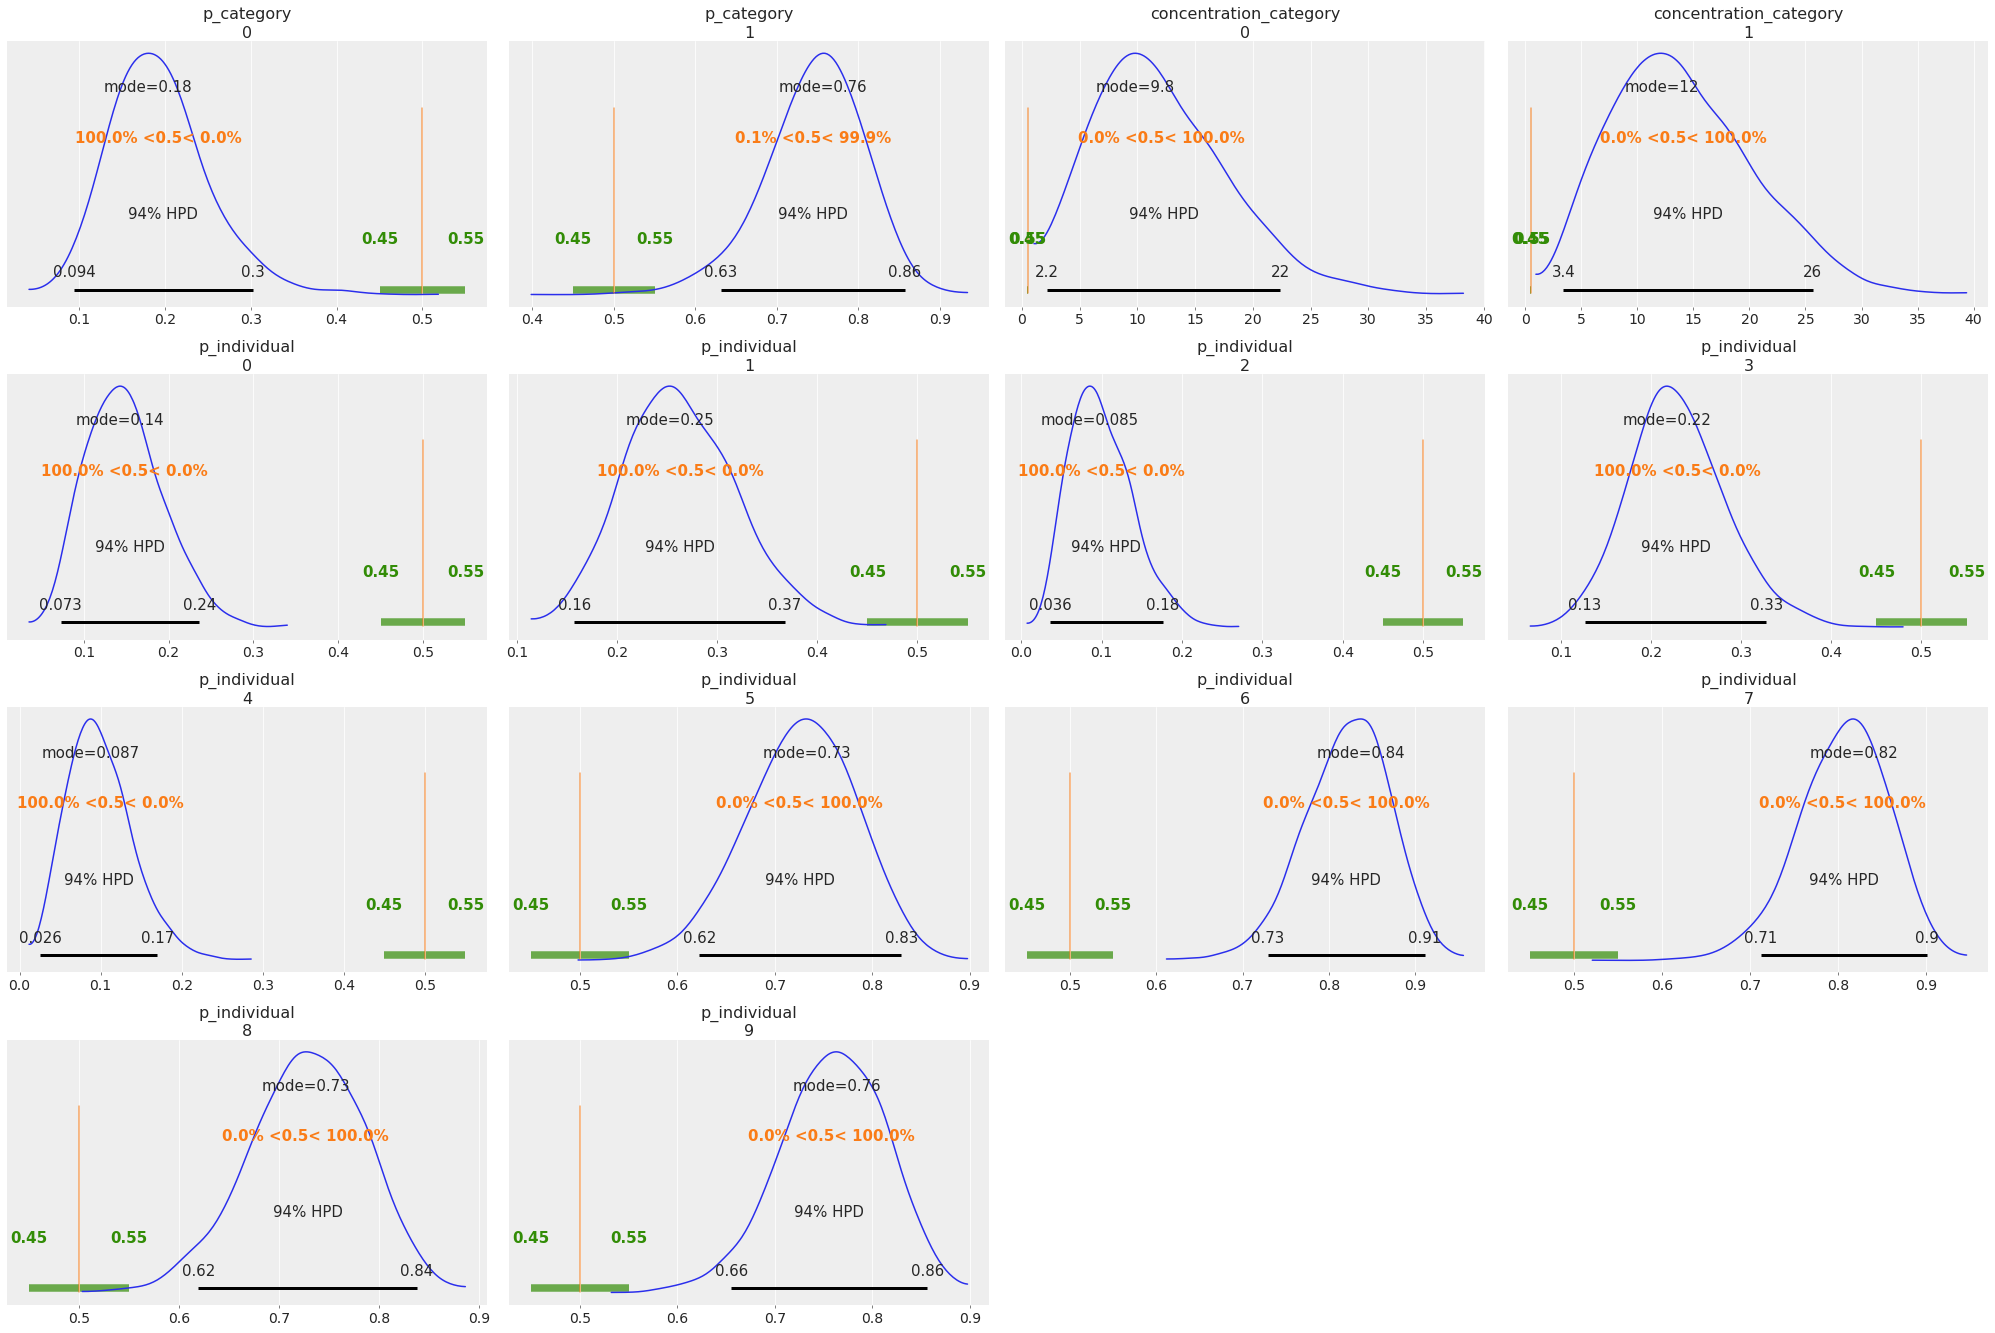

In [24]:
with pm.Model() as model_h:
  p_category = pm.Beta('p_category', 1, 1, shape=num_categories)
  concentration_category = pm.HalfNormal('concentration_category', 10, shape=num_categories)

  p_individual = pm.Beta('p_individual',
                       alpha=p_category[category_id]*concentration_category[category_id],
                       beta=(1.0-p_category[category_id])*concentration_category[category_id],
                       shape=num_individuals)
  
  y = pm.Binomial('y', n=consolidated['attempts'], p=p_individual[individual_id], observed=consolidated['successes']) # likelihood p(y|θ)

  trace_h = pm.sample(2000, random_seed=123)
  print(az.summary(trace_h))
  pm.traceplot(trace_h)
  az.plot_posterior(trace_h, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model_h)

## Heirarchy with Overall

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_individual, concentration_category, p_category, concentration_overall, p_overall]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:07<00:00, 350.66it/s]


                             mean     sd  hpd_3%  ...  ess_bulk  ess_tail  r_hat
p_overall                   0.471  0.150   0.197  ...    3991.0    2707.0    1.0
concentration_overall       4.839  3.409   0.280  ...    3229.0    2553.0    1.0
p_category[0]               0.208  0.068   0.101  ...    2728.0    1781.0    1.0
p_category[1]               0.729  0.069   0.609  ...    2522.0    1404.0    1.0
concentration_category[0]  11.480  5.868   1.783  ...    3094.0    2014.0    1.0
concentration_category[1]  13.452  6.387   2.228  ...    2436.0    1252.0    1.0
p_individual[0]             0.150  0.047   0.061  ...    6038.0    2384.0    1.0
p_individual[1]             0.266  0.059   0.162  ...    8815.0    2964.0    1.0
p_individual[2]             0.101  0.040   0.032  ...    5766.0    3132.0    1.0
p_individual[3]             0.232  0.053   0.126  ...    5979.0    3129.0    1.0
p_individual[4]             0.102  0.040   0.035  ...    6748.0    2667.0    1.0
p_individual[5]             

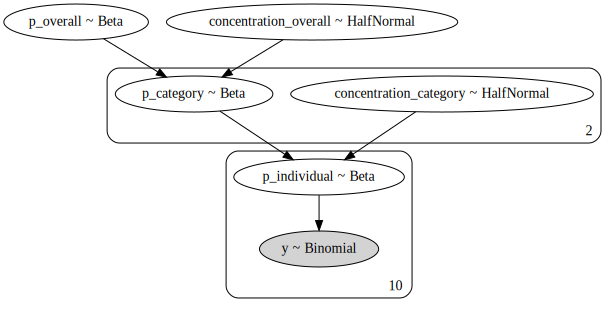

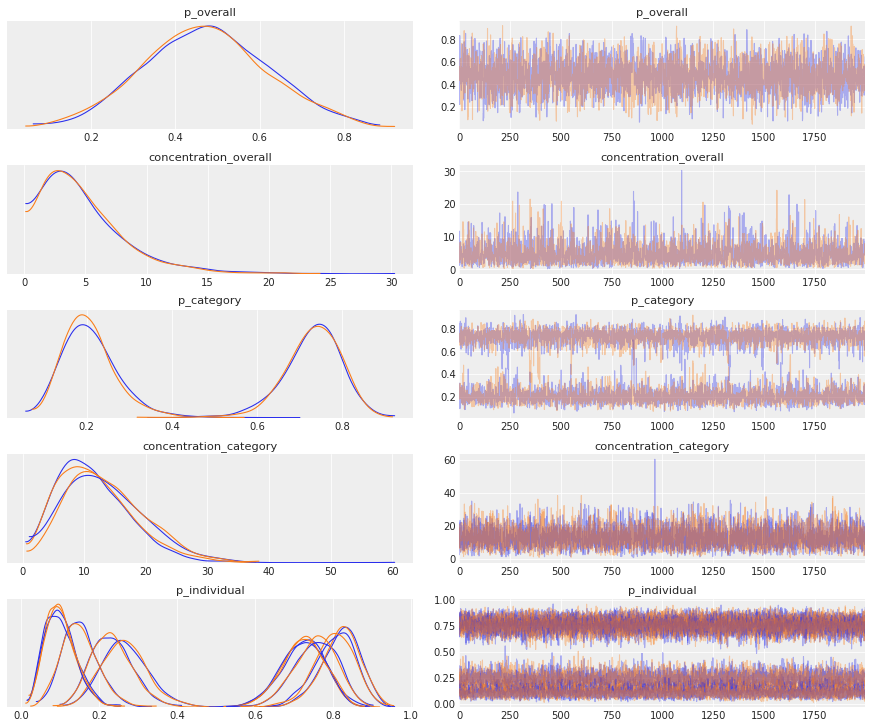

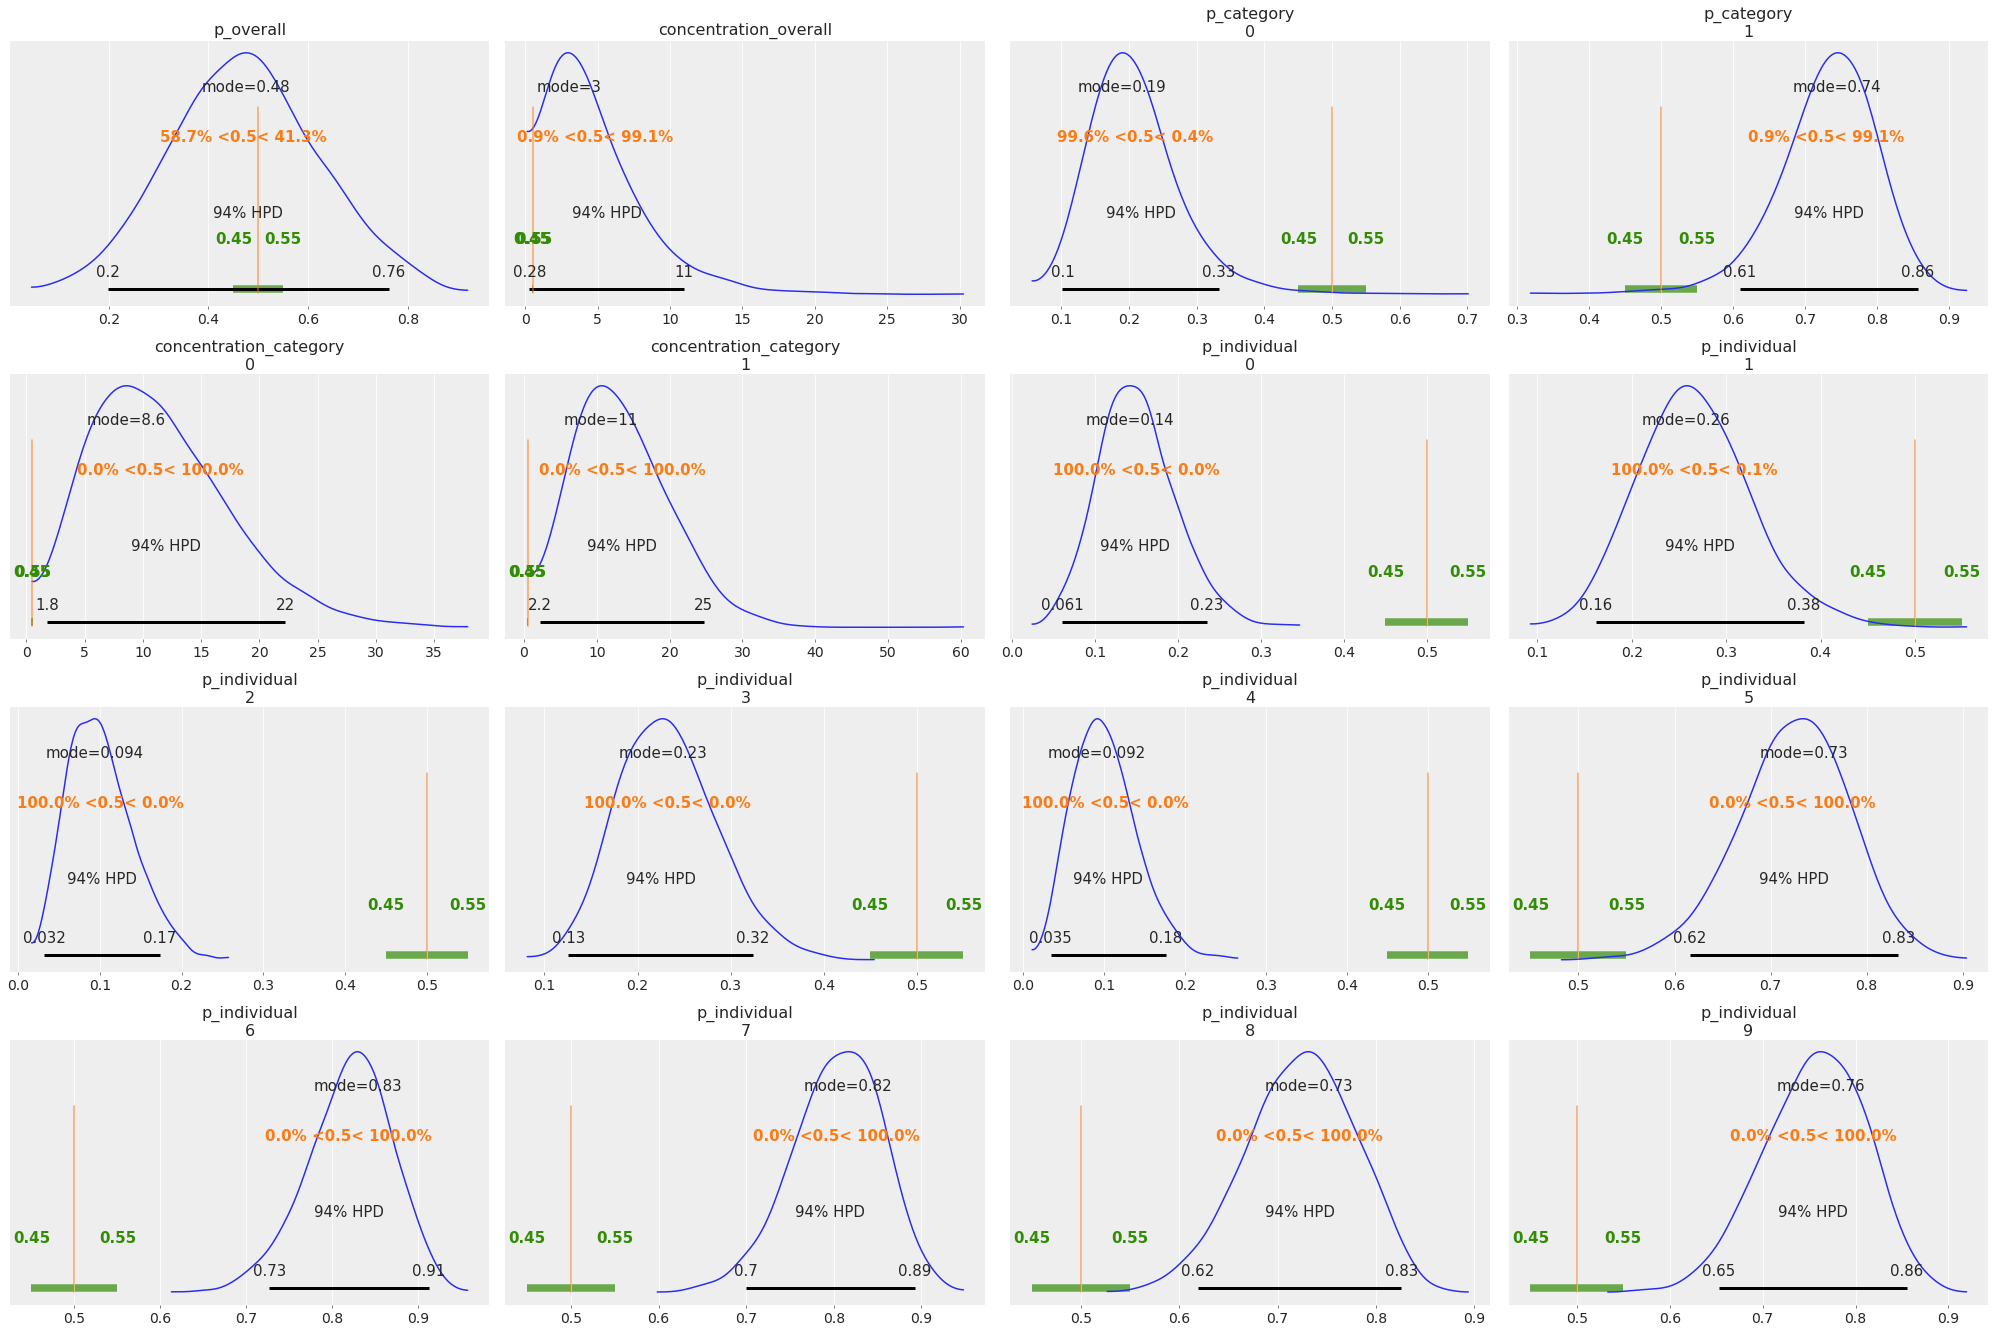

In [25]:
with pm.Model() as model_h_o:
  p_overall = pm.Beta('p_overall', 1, 1)
  concentration_overall = pm.HalfNormal('concentration_overall', 10)

  
  p_category = pm.Beta('p_category',
                       alpha=p_overall*concentration_overall,
                       beta=(1.0-p_overall)*concentration_overall,
                       shape=num_categories)
  concentration_category = pm.HalfNormal('concentration_category', 10, shape=num_categories)

  p_individual = pm.Beta('p_individual',
                       alpha=p_category[category_id]*concentration_category[category_id],
                       beta=(1.0-p_category[category_id])*concentration_category[category_id],
                       shape=num_individuals)
  
  y = pm.Binomial('y', n=consolidated['attempts'], p=p_individual[individual_id], observed=consolidated['successes']) # likelihood p(y|θ)

  trace_h_o = pm.sample(2000, random_seed=123)
  print(az.summary(trace_h_o))
  pm.traceplot(trace_h_o)
  az.plot_posterior(trace_h_o, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model_h_o)